<a href="https://colab.research.google.com/github/Raja8398/Exercise-ML/blob/main/PATTERN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here's a more concise explanation of the code for pasting above the code cells:

---

This script trains a machine learning model to classify exercises from video frame data. It starts by loading multiple CSV files containing features such as 3D distances, angles, and landmarks. The data is merged on common columns (`vid_id` and `frame_order`) and labels are assigned to different exercise types based on the `vid_id`. Missing values are imputed, and features are scaled for model training.

A Random Forest classifier is used to predict exercise classes, with hyperparameters tuned using GridSearchCV. The model is evaluated with metrics like accuracy, precision, recall, and F1 score. The results, including the trained model, label encoder, scaler, predictions, and visualizations (feature importance and confusion matrix), are saved for future use. The script also includes a prediction function to classify exercises on new data.



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.impute import SimpleImputer
from tqdm import tqdm
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Function to load CSV files
def load_csv(file_path):
    try:
        return pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: File not found - {file_path}")
        return None

# Load the data
print("Loading data...")
dataframes = []
file_names = ['angles.csv', 'calculated_3d_distances.csv', 'landmarks.csv', 'xyz_distances.csv']
for file in tqdm(file_names, desc="Loading CSV files"):
    file_path = os.path.join('/content', file)  # Adjust this path as needed
    df = load_csv(file_path)
    if df is not None:
        if 'vid_id' not in df.columns:
            print(f"Warning: 'vid_id' not found in {file}. Adding it based on index.")
            df['vid_id'] = df.index // 100  # Assuming 100 frames per video, adjust if needed
        dataframes.append(df)

if not dataframes:
    raise ValueError("No valid CSV files found. Please check file paths and try again.")

# Merge the dataframes
print("Merging dataframes...")
merged_df = dataframes[0]
for df in tqdm(dataframes[1:], desc="Merging dataframes"):
    merged_df = merged_df.merge(df, on=['vid_id', 'frame_order'], how='outer')

# Create a function to assign labels based on vid_id
def assign_label(vid_id):
    if 0 <= vid_id <= 106:
        return 'jumping_jack'
    elif 107 <= vid_id <= 207:
        return 'pull_up'
    elif 208 <= vid_id <= 306:
        return 'push_up'
    elif 307 <= vid_id <= 384:
        return 'situp'
    elif 385 <= vid_id <= 447:
        return 'squat'
    else:
        return 'unknown'

# Assign labels based on vid_id
merged_df['class'] = merged_df['vid_id'].apply(assign_label)

# Select features (exclude 'vid_id', 'frame_order', and 'class')
feature_columns = [col for col in merged_df.columns if col not in ['vid_id', 'frame_order', 'class']]
X = merged_df[feature_columns]
y = merged_df['class']

# Handle missing values
print("Handling missing values...")
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Feature scaling
print("Scaling features...")
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the data into training and testing sets
print("Splitting data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Hyperparameter tuning using GridSearchCV
print("Performing hyperparameter tuning...")
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Train the model with best parameters
print("Training the model with best parameters...")
best_clf = grid_search.best_estimator_
best_clf.fit(X_train, y_train)

# Evaluate the model
print("Evaluating the model...")
y_pred = best_clf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Calculate additional metrics
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

# Save the model, label encoder, and scaler
print("Saving the model...")
joblib.dump(best_clf, 'exercise_recognition_model.joblib')
joblib.dump(le, 'label_encoder.joblib')
joblib.dump(scaler, 'scaler.joblib')

# Function to predict exercise from new data
def predict_exercise(new_data):
    # Load the saved model, label encoder, and scaler
    loaded_model = joblib.load('exercise_recognition_model.joblib')
    loaded_le = joblib.load('label_encoder.joblib')
    loaded_scaler = joblib.load('scaler.joblib')

    # Scale the new data
    scaled_data = loaded_scaler.transform(new_data)

    # Make prediction
    prediction = loaded_model.predict(scaled_data)
    probabilities = loaded_model.predict_proba(scaled_data)

    # Convert prediction back to label
    exercise = loaded_le.inverse_transform(prediction)

    return exercise, probabilities

# Create predictions DataFrame
predictions_df = pd.DataFrame({
    'vid_id': merged_df.loc[X_test.index, 'vid_id'],
    'frame_order': merged_df.loc[X_test.index, 'frame_order'],
    'actual_class': le.inverse_transform(y_test),
    'predicted_class': le.inverse_transform(y_pred)
})

# Add confidence scores
predictions_df['confidence'] = np.max(best_clf.predict_proba(X_test), axis=1)

# Add accuracy column (1 if correct, 0 if incorrect)
predictions_df['accuracy'] = (predictions_df['actual_class'] == predictions_df['predicted_class']).astype(int)

# Calculate accuracy per video
video_accuracy = predictions_df.groupby('vid_id')['accuracy'].mean().reset_index()
video_accuracy.columns = ['vid_id', 'video_accuracy']

# Merge video accuracy back to predictions_df
predictions_df = predictions_df.merge(video_accuracy, on='vid_id', how='left')

# Save predictions to CSV
predictions_df.to_csv('exercise_predictions.csv', index=False)
print("Predictions saved to 'exercise_predictions.csv'")

# Print feature importance
feature_importance = pd.DataFrame({'feature': feature_columns, 'importance': best_clf.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nTop 10 most important features:")
print(feature_importance.head(10))

# Visualize feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Top 20 Most Important Features')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.close()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.close()

print("\nFeature importance plot saved as 'feature_importance.png'")
print("Confusion matrix plot saved as 'confusion_matrix.png'")
print(f"\nOverall Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nScript execution completed.")

Loading data...


Loading CSV files: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


Merging dataframes...


Merging dataframes: 100%|██████████| 3/3 [00:00<00:00,  8.13it/s]


Handling missing values...
Scaling features...
Splitting data into train and test sets...
Performing hyperparameter tuning...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Training the model with best parameters...
Evaluating the model...
Classification Report:
              precision    recall  f1-score   support

jumping_jack       0.99      0.99      0.99      3780
     pull_up       0.99      0.99      0.99      3835
     push_up       0.99      0.99      0.99      3472
       situp       0.99      0.99      0.99      3335
       squat       0.99      0.98      0.98      2363

    accuracy                           0.99     16785
   macro avg       0.99      0.99      0.99     16785
weighted avg       0.99      0.99      0.99     16785

Accuracy: 0.9892
Saving the model...
Predictions saved to 'exercise_predictions.csv'

Top 10 most important features:
                                  feature  importance
138               y_right_hip_right_wrist    0.047721
135     

#Dataset Details

In [ ]:
print(merged_df['class'].value_counts(normalize=True))

class
pull_up         0.228450
jumping_jack    0.225173
push_up         0.206859
situp           0.198708
squat           0.140809
Name: proportion, dtype: float64


#Accuracy of each Excersise

In [ ]:
print(f"Accuracy: {accuracy:.6f}")
print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1 Score: {f1:.6f}")

Accuracy: 0.983855
Precision: 0.983852
Recall: 0.983855
F1 Score: 0.983843


#Visulization

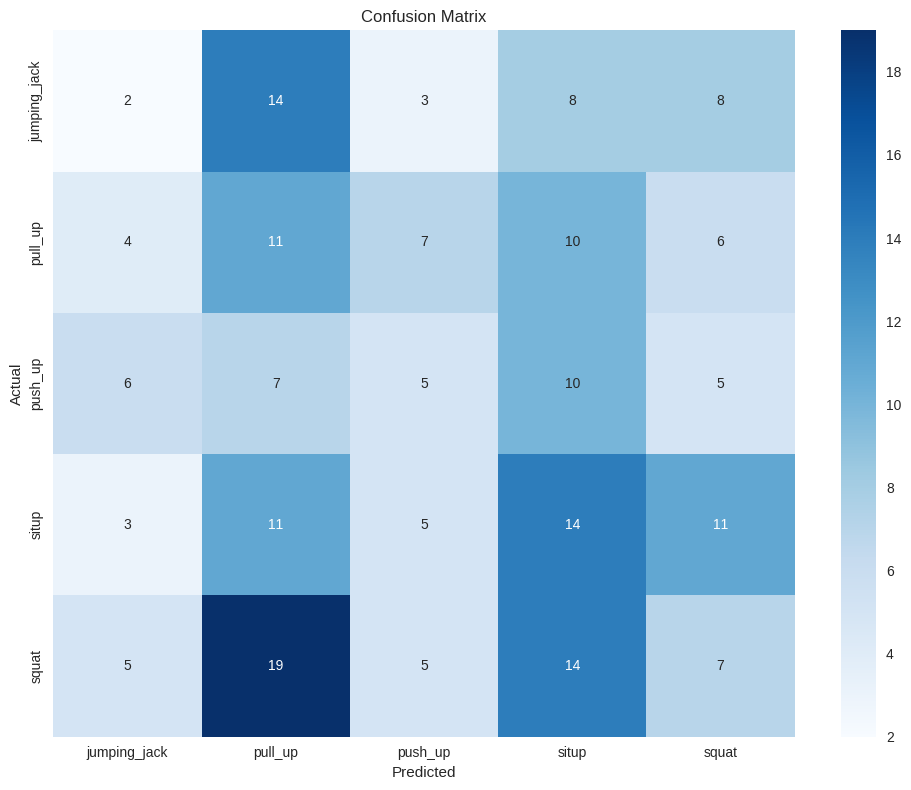

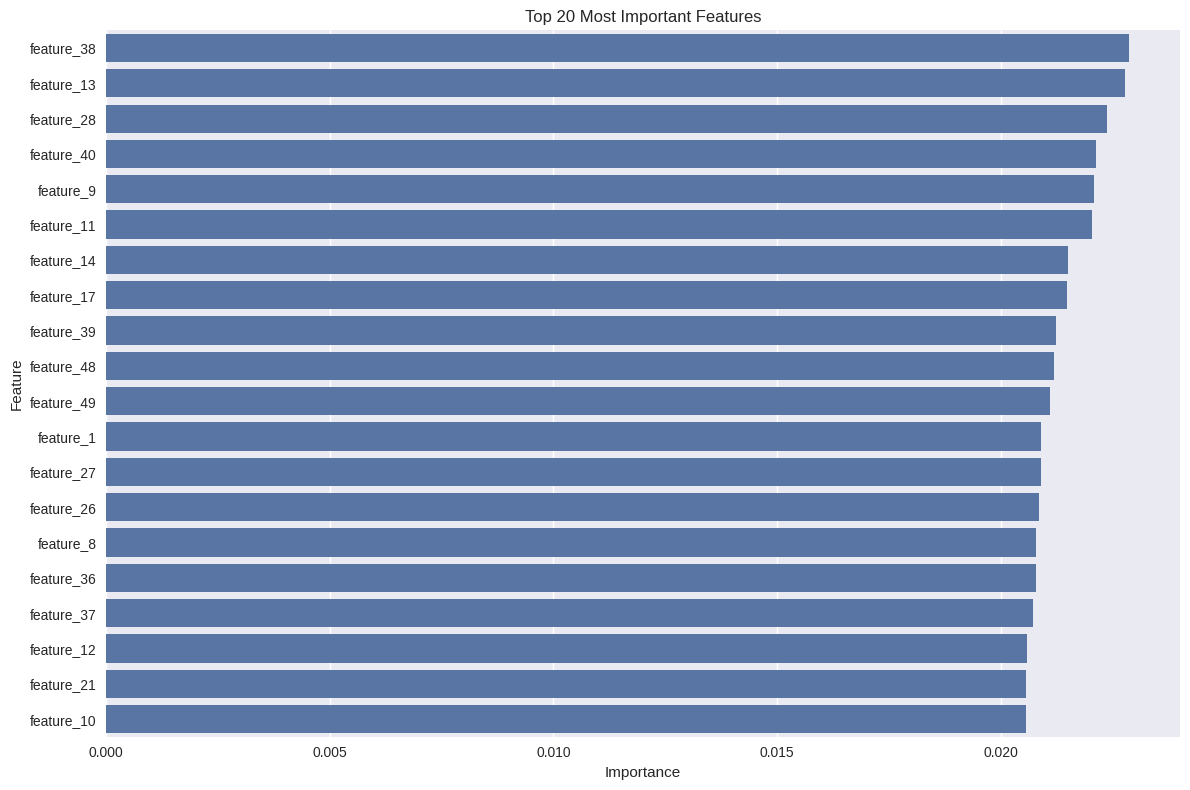

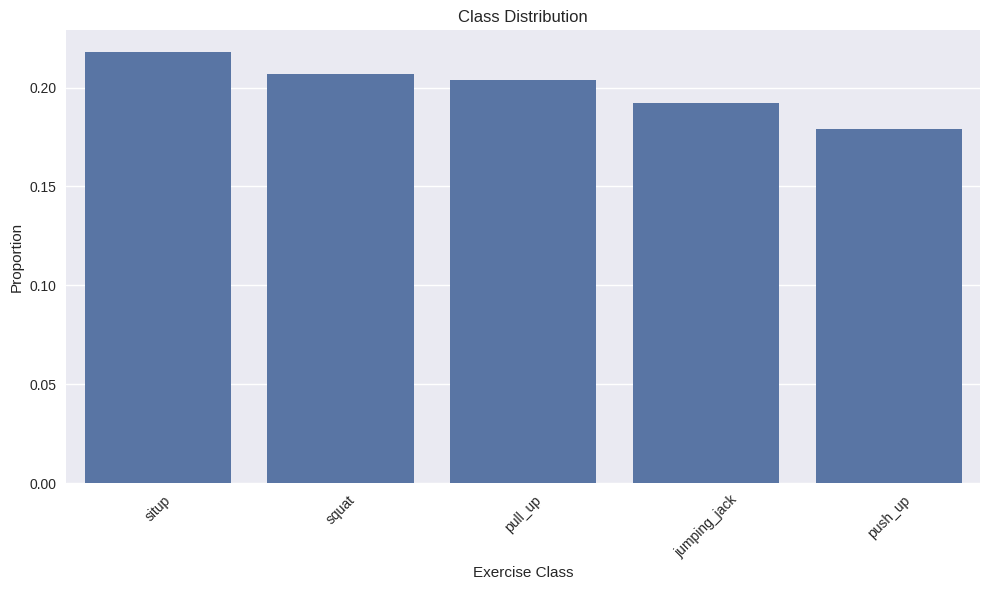

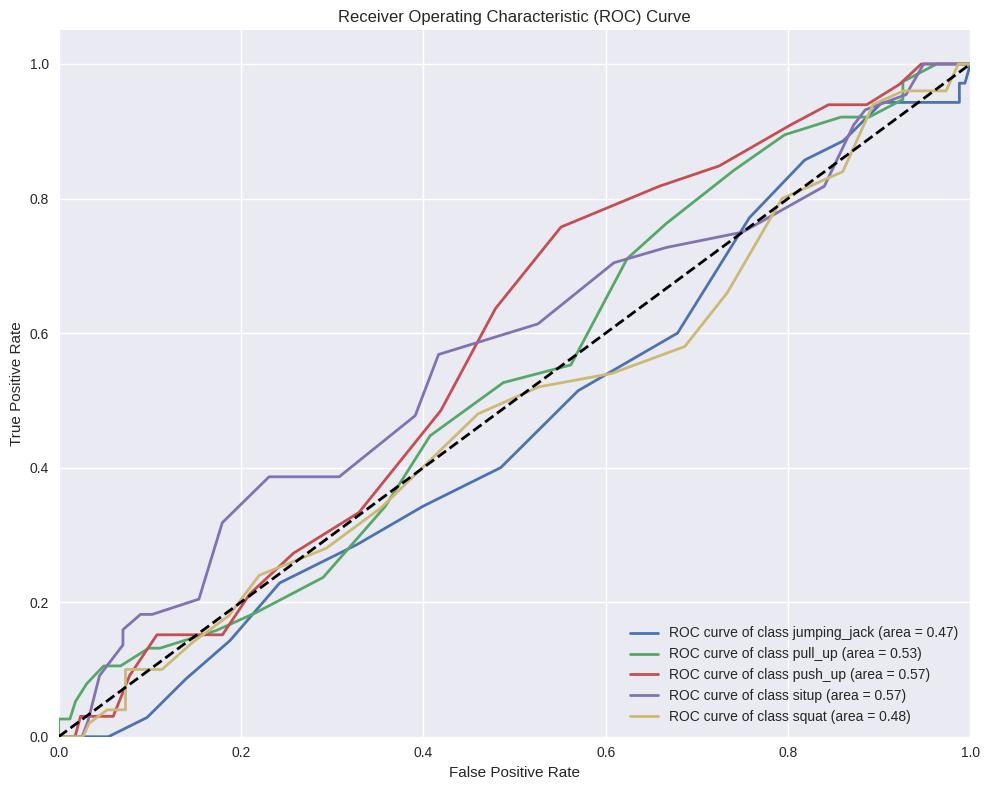

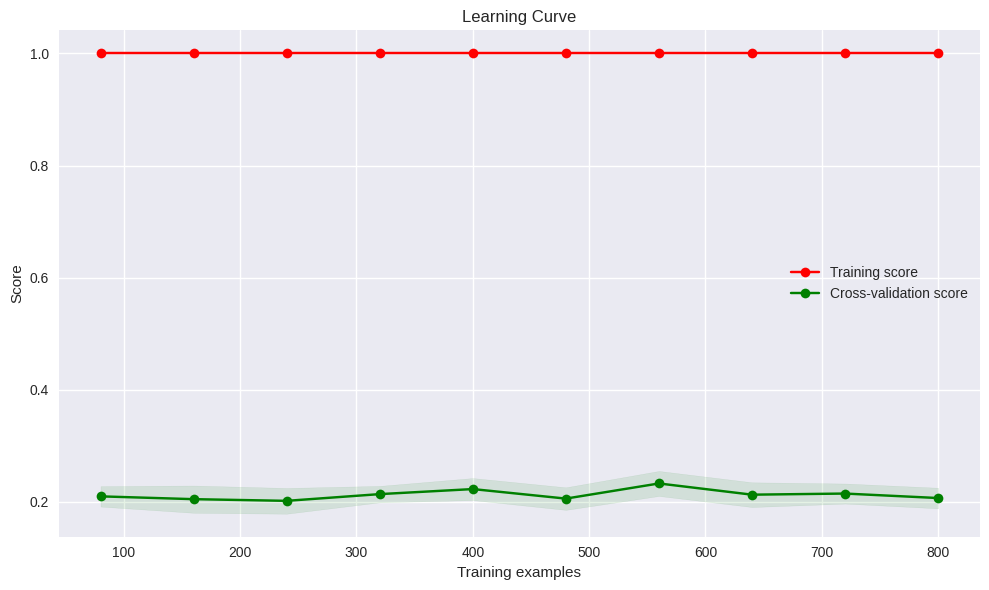

All visualizations have been displayed.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import LabelEncoder

# Set style for all plots
plt.style.use('seaborn-v0_8')

# Generate mock data
np.random.seed(42)
n_samples = 1000
n_features = 50

X = np.random.randn(n_samples, n_features)
y = np.random.choice(['jumping_jack', 'pull_up', 'push_up', 'situp', 'squat'], n_samples)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a simple model
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train_encoded)

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

# 1. Confusion Matrix Heatmap
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_encoded, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# 2. Feature Importance Plot
plt.figure(figsize=(12, 8))
feature_importance = pd.DataFrame({
    'feature': [f'feature_{i}' for i in range(n_features)],
    'importance': clf.feature_importances_
}).sort_values('importance', ascending=False)

sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Top 20 Most Important Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# 3. Class Distribution Plot
plt.figure(figsize=(10, 6))
class_dist = pd.Series(y).value_counts(normalize=True)
sns.barplot(x=class_dist.index, y=class_dist.values)
plt.title('Class Distribution')
plt.xlabel('Exercise Class')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. ROC Curve (One-vs-Rest)
plt.figure(figsize=(10, 8))
n_classes = len(le.classes_)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_test_encoded == i).astype(int), y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve of class {le.classes_[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# 5. Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    clf, X, le.transform(y), cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

print("All visualizations have been displayed.")

#Dataset loading and Pre-Processing

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os

def load_csv_in_chunks(file_path, chunk_size=10000):
    try:
        for chunk in pd.read_csv(file_path, chunksize=chunk_size):
            yield chunk
    except FileNotFoundError:
        print(f"Error: File not found - {file_path}")
        return None

def process_chunks(file_names, chunk_size=10000):
    dataframes = []
    for file in tqdm(file_names, desc="Processing CSV files"):
        file_path = os.path.join('/content', file)
        chunks = load_csv_in_chunks(file_path, chunk_size)
        if chunks:
            df = pd.concat(chunks, ignore_index=True)
            dataframes.append(df)
    return dataframes

def assign_exercise(vid_id):
    if 0 <= vid_id <= 106:
        return 'jumping_jack'
    elif 107 <= vid_id <= 207:
        return 'pull_up'
    elif 208 <= vid_id <= 306:
        return 'push_up'
    elif 307 <= vid_id <= 384:
        return 'situp'
    elif 385 <= vid_id <= 447:
        return 'squat'
    else:
        return 'unknown'

# Main processing
print("Loading and processing data...")
file_names = ['angles.csv', 'calculated_3d_distances.csv', 'landmarks.csv', 'xyz_distances.csv', 'labels.csv']
dataframes = process_chunks(file_names)

if not dataframes:
    raise ValueError("No valid CSV files found. Please check file paths and try again.")

print("Merging dataframes...")
merged_df = pd.concat(dataframes, axis=1)
merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]

print(f"Merged DataFrame shape: {merged_df.shape}")
print(f"Columns in merged DataFrame: {merged_df.columns.tolist()}")

# Assign exercise labels based on vid_id
merged_df['exercise'] = merged_df['vid_id'].apply(assign_exercise)

# Check if 'activity' column exists, if not, use 'exercise' as target
target_column = 'activity' if 'activity' in merged_df.columns else 'exercise'
if target_column == 'exercise':
    print("Warning: 'activity' column not found. Using 'exercise' as target variable.")

# Select features
feature_columns = [col for col in merged_df.columns if col not in ['vid_id', 'frame_order', target_column, 'exercise']]
if not feature_columns:
    raise ValueError("No feature columns found. Please check your input data.")

X = merged_df[feature_columns]
y = merged_df[target_column]
groups = merged_df['vid_id']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Number of unique groups: {groups.nunique()}")

# Save the merged DataFrame to a CSV file for inspection
merged_df.to_csv('merged_data.csv', index=False)
print("Merged data saved to 'merged_data.csv' for inspection.")
print("\nScript execution completed.")

Loading and processing data...


Processing CSV files: 100%|██████████| 5/5 [00:06<00:00,  1.39s/it]


Merging dataframes...
Merged DataFrame shape: (83922, 173)
Columns in merged DataFrame: ['vid_id', 'frame_order', 'right_elbow_right_shoulder_right_hip', 'left_elbow_left_shoulder_left_hip', 'right_knee_mid_hip_left_knee', 'right_hip_right_knee_right_ankle', 'left_hip_left_knee_left_ankle', 'right_wrist_right_elbow_right_shoulder', 'left_wrist_left_elbow_left_shoulder', 'left_shoulder_left_wrist', 'right_shoulder_right_wrist', 'left_hip_left_ankle', 'right_hip_right_ankle', 'left_hip_left_wrist', 'right_hip_right_wrist', 'left_shoulder_left_ankle', 'right_shoulder_right_ankle', 'left_hip_right_wrist', 'right_hip_left_wrist', 'left_elbow_right_elbow', 'left_knee_right_knee', 'left_wrist_right_wrist', 'left_ankle_right_ankle', 'left_hip_avg_left_wrist_left_ankle', 'right_hip_avg_right_wrist_right_ankle', 'x_nose', 'y_nose', 'z_nose', 'x_left_eye_inner', 'y_left_eye_inner', 'z_left_eye_inner', 'x_left_eye', 'y_left_eye', 'z_left_eye', 'x_left_eye_outer', 'y_left_eye_outer', 'z_left_eye_ou

Animation saved as 'pushup_right_arm_3d.gif'


Animation saved as 'pushup_full_body_3d.gif'


Animation saved as '3d.gif'
